# 分析台北市雨量和空氣品質指標(AQI)的關係圖



### 從我的Google drive讀取資料

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 下載pandas_ods_reader

In [2]:
!pip install pandas_ods_reader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 7.8 MB/s 
  Created wheel for ezodf: filename=ezodf-0.3.2-py2.py3-none-any.whl size=49002 sha256=e872a584853bf3b9d22dba1cfc0a19a0aa435efd0707a940e7fb4f0370cf9fc5
  Stored in directory: /root/.cache/pip/wheels/8f/60/52/bffa36b97e0136aa62d54948d56e8770b96a5da7f9c65fdd85
Successfully built ezodf


### 程式碼
如果無法讀取到檔案請下載作業中所附的壓縮檔，解壓縮後把「110405188傳院二邱品慈期中專案」這個資料夾上傳到自己google drive的「我的雲端硬碟」上，應該就可以跑了!

           Percipitation        AQI
January             41.0  45.282353
February            46.5  76.882353
March               77.5  57.705882
April               60.0  66.858824
May                119.5  70.352941
June               316.5  48.552941
July               288.0  47.176471
August             409.0  45.952381
September          181.5  43.481013
October            245.0  38.064103
November            70.0  53.628205
December            54.0  51.367816 

相關係數:
 -0.5331978714297576 



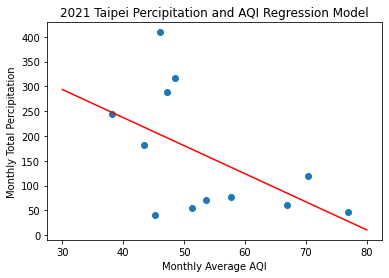

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from pandas_ods_reader import read_ods
import xml.etree.ElementTree as et
import os
import numpy as np
from sklearn import linear_model
# 設定讀取資料路徑
PATH = '/content/drive/My Drive/110405188傳院二邱品慈期中專案'
os.chdir(PATH)

# 解析xml 得到臺北2021年各月總雨量資料
data = et.parse('dy_Report_2021.xml')
root = data.getroot()
ns = {'g':'urn:cwb.gov.tw:cwbdata-0.1'}             # xml namespace
parent_map = {c: p for p in root.iter() for c in p}  # 用來找xml各層的上一層是什麼的parent_map
percipitation = []
for stationName in root.findall('./g:resources/g:resource/g:data/g:surfaceObs/g:location/g:station/g:stationName',ns):
  if stationName.text == '臺北':
    station = parent_map[stationName]
    location = parent_map[station]
    for monthly_total in location.findall('./g:stationObsStatistics/g:precipitation/g:monthly/g:total', ns):
      percipitation.append(float(monthly_total.text))

# 讀取ods資料 得到臺北2021年各月平均AQI
avg_aqi = []
for i in range(1,13):
  m = "0"+str(i) if i < 10 else str(i)
  file = '/2021各月AQI資料/2021'+m+'01_2021'+m+'07_日資料.ods'
  aqi_data = read_ods(os.curdir+file, headers=False)
  avg_aqi.append(sum(aqi_data.loc[1:,"column.2"])/len(aqi_data))

# 印出2021年各月總雨量與各月平均AQI
month = ['January','February','March','April','May','June','July','August','September','October','November','December']
paqi = list(zip(percipitation,avg_aqi))
PAQI_df = pd.DataFrame(paqi)
PAQI_df.index = month
PAQI_df.columns = ["Percipitation","AQI"]
print(PAQI_df,'\n')

# 用skylearn來迴歸分析相關性
relation = linear_model.LinearRegression()
relation.fit(np.array(avg_aqi).reshape(-1, 1), percipitation)
xfit = np.linspace(30,80,1000)
yfit = relation.predict(xfit[:,np.newaxis])
print("相關係數:\n",PAQI_df.corr().loc["Percipitation","AQI"], '\n')

# 印出迴歸直線和散點圖
plt.title("2021 Taipei Percipitation and AQI Regression Model")
plt.xlabel("Monthly Average AQI")
plt.ylabel("Monthly Total Percipitation")
plt.scatter(avg_aqi, percipitation)
plt.plot(xfit,yfit, color = 'red')
plt.show()
